# 인물사진 만들기

In [1]:
# 사용할 패키지 불러오기
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
# urllib 패키지는 웹에서 데이터를 다운로드 받을 때 사용
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 준비한 이미지 읽기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
# 3번 작업위해 미리 사이즈 조정
img_orig = cv2.resize(img_orig, dsize=(2560,1440), interpolation=cv2.INTER_AREA)
print (img_orig.shape)

(1440, 2560, 3)


## 세그멘테이션으로 사람 분리

* 구글 딥랩모델 사용

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight (사전학습된 가중치 로드)
# 구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac26/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# 사진 사이즈가 줄어듬

(1440, 2560, 3) (288, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

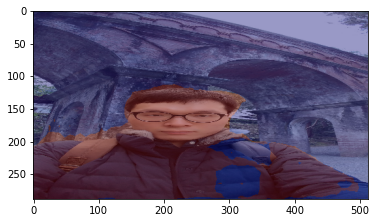

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# (2560, 1440, 3)
# (513, 288, 3) 15
img_show.shape

(288, 513, 3)

## 세그멘테이션 결과를 원래크기로 복원

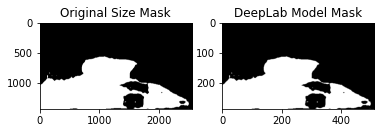

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# 중간값인 128을 기준으로 임계값(threshold)설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [10]:
img_mask_up.shape, img_mask.shape

((1440, 2560), (288, 513))

## 배경 흐리게 하기

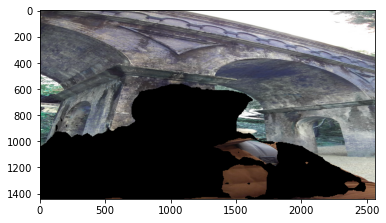

In [11]:
#bitwise_not함수로 반전
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상나옴
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [12]:
img_bg_mask.shape, img_bg.shape

((1440, 2560, 3), (1440, 2560, 3))

In [13]:
# 원본 :(2560,1440) img_mask_up.shape,
# reshape : (513,288) img_mask.shape

In [14]:
img_bg.shape

(1440, 2560, 3)

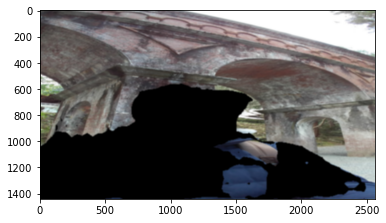

In [15]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 흐린배경과 원본 합성


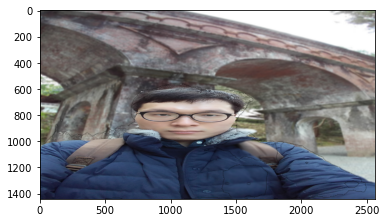

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# np.where(a < 5, a, 10*a)
## True이면 x를 산출 하고 그렇지 않으면 y를 산출 합니다.

## 문제점 찾기

* 인물사진의 문제점 : 가방을 메고찍은 사진인데 가방끈이 너무 눈에 띈다. 인물영역에 포함되어서 제거는 힘들것 같다.
* 블러효과가 생각만큼 크지않다.


# 고양이 사진 만들기

In [18]:
# 준비한 이미지 읽기
import os
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat1.jpeg'  
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path2) 
print (img_cat.shape)

(287, 523, 3)


* 구글딥랩모델로 세그맨테이션 - 배경과 분리

In [19]:
# 모델로드 부분은 위와 동일 (이해가 힘듬)
img_resized2, seg_map2 = MODEL.run(img_cat)
print (img_cat.shape, img_resized2.shape, seg_map2.max())
# 사진 사이즈가 줄어듬

(287, 523, 3) (281, 513, 3) 8


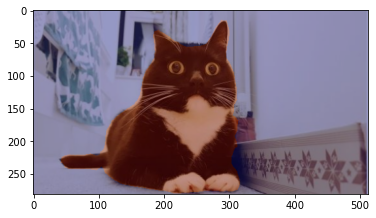

In [20]:
img_show2 = img_resized2.copy()
seg_map2 = np.where(seg_map2 == 8, 8, 0) # 예측 중 고양이만 추출
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()



In [21]:
img_show2.shape

(281, 513, 3)

* 세그멘테이션 결과를 원래크기로 복원

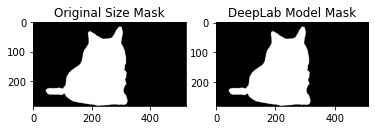

In [22]:
img_mask_up2 = cv2.resize(img_mask2, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)
# 중간값인 128을 기준으로 임계값(threshold)설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


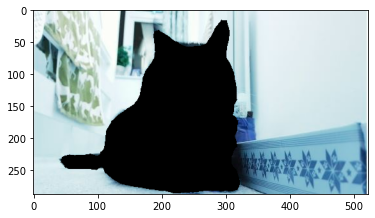

In [23]:
#bitwise_not함수로 반전
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상나옴
img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg2 = cv2.bitwise_and(img_cat, img_bg_mask2)
plt.imshow(img_bg2)
plt.show()

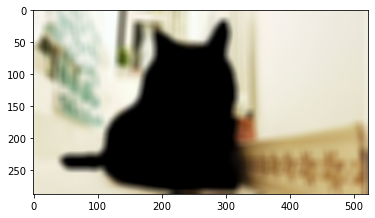

In [24]:
img_bg_blur2 = cv2.blur(img_bg2, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

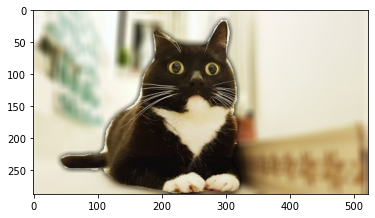

In [25]:
img_concat2 = np.where(img_mask_color2==255, img_cat, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

* 인물사진에 비해 고양이 사진은 배경의 블러처리가 잘되었다. 
* 고양이의 테두리가 약간 부자연스럽게 튀는 느낌

# 다른사진에 합성하기

* 배경만 있는사진 블러처리

In [27]:
# 준비한 이미지 읽기
import os
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/col1.jpg'  
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_col = cv2.imread(img_path3) 
print (img_col.shape)

(897, 1280, 3)


In [28]:
# 인물사진과 사이즈 같게 조정
# 인물사진의 이상이 있는지 x,y 좌표가 반대로 나옴
col_1 = cv2.resize(img_col, dsize=(2560,1440), interpolation=cv2.INTER_AREA)

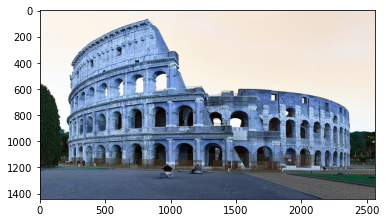

In [29]:
plt.imshow(col_1)
plt.show()

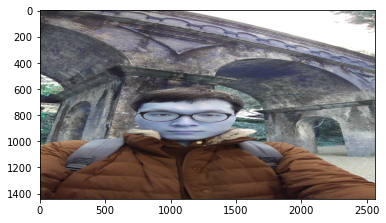

In [30]:
plt.imshow(img_orig)
plt.show()

In [31]:
col_1.shape, img_orig.shape

((1440, 2560, 3), (1440, 2560, 3))

* 이미지 블러처리

In [32]:
# 모델로드 부분은 위와 동일 (이해가 힘듬)
img_resized3, seg_map3 = MODEL.run(col_1)
print (col_1.shape, img_resized3.shape, seg_map3.max())
# 사진 사이즈가 줄어듬

(1440, 2560, 3) (288, 513, 3) 0


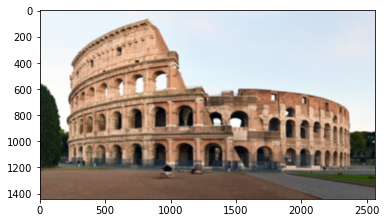

In [33]:
img_bg_blur3 = cv2.blur(col_1, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

* 인물 이미지만 빼내기 

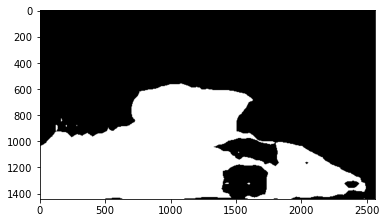

In [37]:
plt.imshow(img_mask_color)
plt.show()

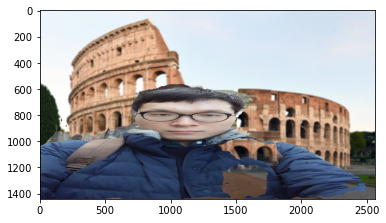

In [38]:
img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur3)
# rgb가 255(흰색)이면 img_orig사용, 아닐시 블러3사용해서 이미지 결합
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 인물 세그멘테이션 결과에 부정확한 부분이 존재한다. 같은 사진내에서 블러처리하는덴 이상없었으나, 다른 사진과 합성시
# 문제 발생했다. 원본 크기를 조정하면서 확장된 픽셀을 보충하는 interpolation=cv2.INTER_AREA (추정)
# 시에 문제가 발생한 것인가?
# 딥랩의 세그멘테이션 부분이 어려워서 함수와 불러오기 부분은 따라하는게 간신히였다.